<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment_10/Task_2_assignment_10_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Data loading with added Gaussian noise

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
LATENT_DIM = 128
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 1e-3

# Data loading with added Gaussian noise
def add_noise(imgs, mean=0.0, std=0.1):
    noise = torch.randn_like(imgs) * std + mean
    noisy_imgs = imgs + noise
    return torch.clip(noisy_imgs, 0., 1.)

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 170M/170M [00:04<00:00, 40.2MB/s]


In [3]:
# Autoencoder definition
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32, 1024),
            nn.ReLU(),
            nn.Linear(1024, LATENT_DIM)
        )
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3*32*32),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 32, 32))
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [4]:
# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for clean_imgs, _ in train_loader:
        clean_imgs = clean_imgs.to(device)
        noisy_imgs = add_noise(clean_imgs).to(device)

        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss / len(train_loader):.4f}")

# Save model for reuse
torch.save(model.state_dict(), "denoising_autoencoder.pth")


Epoch [1/20], Loss: 0.0248
Epoch [2/20], Loss: 0.0144
Epoch [3/20], Loss: 0.0124
Epoch [4/20], Loss: 0.0110
Epoch [5/20], Loss: 0.0106
Epoch [6/20], Loss: 0.0096
Epoch [7/20], Loss: 0.0091
Epoch [8/20], Loss: 0.0088
Epoch [9/20], Loss: 0.0085
Epoch [10/20], Loss: 0.0082
Epoch [11/20], Loss: 0.0167
Epoch [12/20], Loss: 0.0130
Epoch [13/20], Loss: 0.0122
Epoch [14/20], Loss: 0.0115
Epoch [15/20], Loss: 0.0113
Epoch [16/20], Loss: 0.0111
Epoch [17/20], Loss: 0.0109
Epoch [18/20], Loss: 0.0108
Epoch [19/20], Loss: 0.0106
Epoch [20/20], Loss: 0.0105


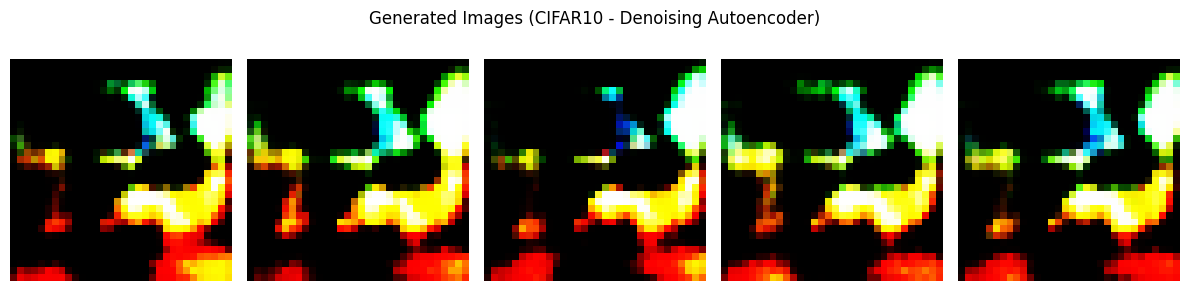

In [5]:
# GENERATION SECTION
model.eval()
with torch.no_grad():
    z = torch.normal(mean=5, std=1, size=(5, LATENT_DIM)).to(device)
    generated_imgs = model.decoder(z).cpu()

# Plotting
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i, ax in enumerate(axes):
    img = np.transpose(generated_imgs[i].numpy(), (1, 2, 0))
    ax.imshow(img)
    ax.axis('off')
fig.suptitle("Generated Images (CIFAR10 - Denoising Autoencoder)")
plt.tight_layout()
plt.show()
